# **Homework 1: Linear Regression**

本次目標：由前 9 個小時的 18 個 features (包含 PM2.5)預測的 10 個小時的 PM2.5。<!-- 可以參考 <link> 獲知更細項的作業說明。-->

<!-- 首先，從 https://drive.google.com/open?id=1El0zvTkrSuqCTDcMpijXpADvJzZC2Jpa 將整個資料夾下載下來，並將下載下來的資料夾放到自己的 Google Drive（注意：上傳到自己 Google Drive 的是資料夾 hw1-regression，而非壓縮檔） -->


若有任何問題，歡迎來信至助教信箱 ntu-ml-2020spring-ta@googlegroups.com

# **Load 'train.csv'**
train.csv 的資料為 12 個月中，每個月取 20 天，每天 24 小時的資料(每小時資料有 18 個 features)。

In [1]:
import sys
import pandas as pd
import numpy as np
from google.colab import drive
!gdown --id '1wNKAxQ29G15kgpBy_asjTcZRRgmsCZRm' --output data.zip
!unzip -o data.zip
# data = pd.read_csv('gdrive/My Drive/hw1-regression/train.csv', header = None, encoding = 'big5')
data = pd.read_csv('./train.csv', encoding = 'big5')

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1wNKAxQ29G15kgpBy_asjTcZRRgmsCZRm
To: /content/data.zip
100% 177k/177k [00:00<00:00, 30.1MB/s]
Archive:  data.zip
  inflating: test.csv                
  inflating: train.csv               


# **Preprocessing**
取需要的數值部分，將 'RAINFALL' 欄位全部補 0。
另外，如果要在 colab 重覆這段程式碼的執行，請從頭開始執行(把上面的都重新跑一次)，以避免跑出不是自己要的結果（若自己寫程式不會遇到，但 colab 重複跑這段會一直往下取資料。意即第一次取原本資料的第三欄之後的資料，第二次取第一次取的資料掉三欄之後的資料，...）。

In [2]:
data = data.iloc[:, 3:]
data[data == 'NR'] = 0
raw_data = data.to_numpy()

# **Extract Features (1)**
![圖片說明](https://drive.google.com/uc?id=1LyaqD4ojX07oe5oDzPO99l9ts5NRyArH)
![圖片說明](https://drive.google.com/uc?id=1ZroBarcnlsr85gibeqEF-MtY13xJTG47)

將原始 4320 * 18 的資料依照每個月分重組成 12 個 18 (features) * 480 (hours) 的資料。

In [3]:
month_data = {}
for month in range(12):
    sample = np.empty([18, 480])
    for day in range(20):
        sample[:, day * 24 : (day + 1) * 24] = raw_data[18 * (20 * month + day) : 18 * (20 * month + day + 1), :]
    month_data[month] = sample

# **Extract Features (2)**
![alt text](https://drive.google.com/uc?id=1wKoPuaRHoX682LMiBgIoOP4PDyNKsJLK)
![alt text](https://drive.google.com/uc?id=1FRWWiXQ-Qh0i9tyx0LiugHYF_xDdkhLN)

每個月會有 480hrs，每 9 小時形成一個 data，每個月會有 471 個 data，故總資料數為 471 * 12 筆，而每筆 data 有 9 * 18 的 features (一小時 18 個 features * 9 小時)。

對應的 target 則有 471 * 12 個(第 10 個小時的 PM2.5)

In [4]:
x = np.empty([12 * 471, 18 * 9], dtype = float)
y = np.empty([12 * 471, 1], dtype = float)
for month in range(12):
    for day in range(20):
        for hour in range(24):
            if day == 19 and hour > 14:
                continue
            x[month * 471 + day * 24 + hour, :] = month_data[month][:,day * 24 + hour : day * 24 + hour + 9].reshape(1, -1) #vector dim:18*9 (9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9)
            y[month * 471 + day * 24 + hour, 0] = month_data[month][9, day * 24 + hour + 9] #value
# print(x)
# print(y)

# from sklearn.feature_selection import SelectFromModel
# from sklearn.linear_model import Lasso

# # 特徵選擇
# selector = SelectFromModel(estimator=Lasso(alpha=0.5))
# selector.fit(x, y.ravel())

# feature_mask = selector.get_support()

# for i in range(x.shape[1]):
#     if not feature_mask[i]:
#         x[:, i] = 0

In [5]:
df = pd.DataFrame(x)

In [6]:
df.to_csv('x.csv', index=False)

# **Normalize (1)**


In [7]:
mean_x = np.mean(x, axis = 0) #18 * 9
std_x = np.std(x, axis = 0) #18 * 9
for i in range(len(x)): #12 * 471
    for j in range(len(x[0])): #18 * 9
        if std_x[j] != 0:
            x[i][j] = (x[i][j] - mean_x[j]) / std_x[j]
# x

#**Split Training Data Into "train_set" and "validation_set"**
這部分是針對作業中 report 的第二題、第三題做的簡單示範，以生成比較中用來訓練的 train_set 和不會被放入訓練、只是用來驗證的 validation_set。

In [8]:
import math
x_train_set = x[: math.floor(len(x) * 0.8), :]
y_train_set = y[: math.floor(len(y) * 0.8), :]
x_validation = x[math.floor(len(x) * 0.8): , :]
y_validation = y[math.floor(len(y) * 0.8): , :]
# print(x_train_set)
# print(y_train_set)
# print(x_validation)
# print(y_validation)
# print(len(x_train_set))
# print(len(y_train_set))
# print(len(x_validation))
# print(len(y_validation))

# **Training**
![alt text](https://drive.google.com/uc?id=1xIXvqZ4EGgmxrp7c9r0LOVbcvd4d9H4N)
![alt text](https://drive.google.com/uc?id=1S42g06ON5oJlV2f9RukxawjbE4NpsaB6)
![alt text](https://drive.google.com/uc?id=1BbXu-oPB9EZBHDQ12YCkYqtyAIil3bGj)

(和上圖不同處: 下面的 code 採用 Root Mean Square Error)

因為常數項的存在，所以 dimension (dim) 需要多加一欄；eps 項是避免 adagrad 的分母為 0 而加的極小數值。

每一個 dimension (dim) 會對應到各自的 gradient, weight (w)，透過一次次的 iteration (iter_time) 學習。

## 第一題
使用四種不同的 learning rate 進行 training (其他參數需一致)，作圖並討論其收斂過程（橫軸為 iteration 次數，縱軸為 loss 的大小，四種 learning rate 的收斂線請以不同顏色呈現在一張圖裡做比較）。

In [9]:
# dim = 18 * 9 + 1
# w = np.zeros([dim, 1])
# x = np.concatenate((np.ones([12 * 471, 1]), x), axis = 1).astype(float)
# learning_rate = 100
# iter_time = 1000
# adagrad = np.zeros([dim, 1])
# eps = 0.0000000001
# for t in range(iter_time):
#     loss = np.sqrt(np.sum(np.power(np.dot(x, w) - y, 2))/471/12)#rmse
#     if(t%100==0):
#         print(str(t) + ":" + str(loss))
#     gradient = 2 * np.dot(x.transpose(), np.dot(x, w) - y) #dim*1
#     adagrad += gradient ** 2
#     w = w - learning_rate * gradient / np.sqrt(adagrad + eps)
# np.save('weight.npy', w)
# w

原本 Loss 函數的 (w1, w2, w3, ..., b) 在這裡變為 w 向量，所以 x 需要補 1 來和 w 向量中的 b 相乘

In [10]:
import matplotlib.pyplot as plt
x_all = np.concatenate((np.ones([12 * 471, 1]), x), axis = 1).astype(float)

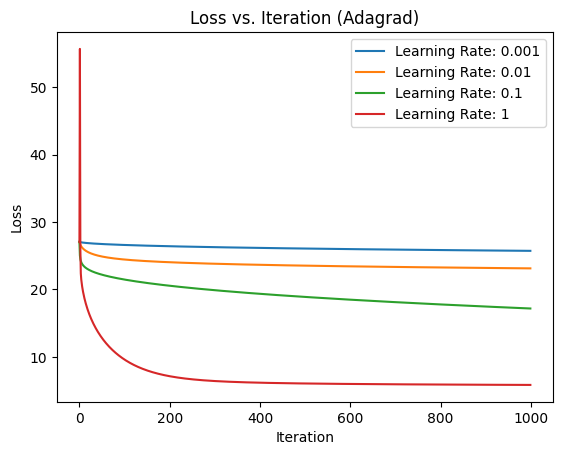

In [11]:
dim = 18 * 9 + 1
iter_time = 1000
all_loss = []
learning_rates = [0.001, 0.01, 0.1, 1]

for learning_rate in learning_rates:
    w = np.zeros([dim, 1])
    adagrad = np.zeros([dim, 1])
    eps = 0.0000000001
    loss_history = []

    for t in range(iter_time):
        loss = np.sqrt(np.sum(np.power(np.dot(x_all, w) - y, 2))/471/12)#rmse
        loss_history.append(loss)
        # if(t%100==0):
        #     print(str(t) + ":" + str(loss))
        gradient = 2 * np.dot(x_all.transpose(), np.dot(x_all, w) - y) #dim*1
        # print(gradient)
        adagrad += gradient ** 2
        w = w - learning_rate * gradient / np.sqrt(adagrad + eps)

    all_loss.append(loss_history)

# 畫圖
for i, loss_history in enumerate(all_loss):
    plt.plot(range(iter_time), loss_history, label=f'Learning Rate: {learning_rates[i]}')

plt.title('Loss vs. Iteration (Adagrad)')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.legend()
plt.show()

Gradient Decent 的 Learning Rate 不能過大，否則會造成 Loss 暴衝

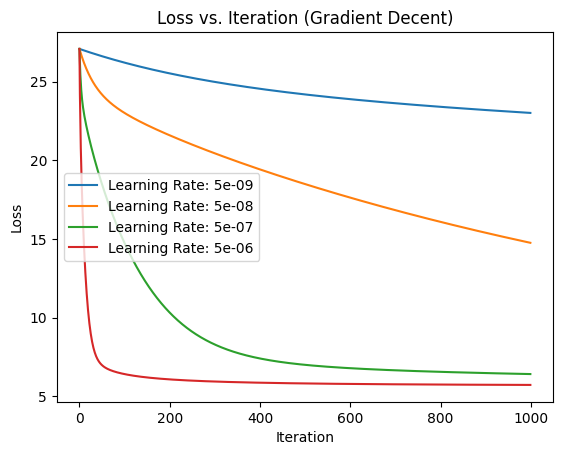

In [12]:
dim = 18 * 9 + 1
iter_time = 1000
all_loss = []
learning_rates = [5e-9, 5e-8, 5e-7, 5e-6]

for learning_rate in learning_rates:
    w = np.zeros([dim, 1])
    loss_history = []

    for t in range(iter_time):
        loss = np.sqrt(np.sum(np.power(np.dot(x_all, w) - y, 2))/471/12)#rmse
        loss_history.append(loss)
        # if(t%100==0):
        #     print(str(t) + ":" + str(loss))
        gradient = 2 * np.dot(x_all.transpose(), np.dot(x_all, w) - y) #dim*1
        # print(gradient)
        w = w - learning_rate * gradient

    all_loss.append(loss_history)
    # 儲存 lr 為 5e-6 的模型
    np.save('weight.npy', w)

# 畫圖
for i, loss_history in enumerate(all_loss):
    plt.plot(range(iter_time), loss_history, label=f'Learning Rate: {learning_rates[i]}')

plt.title('Loss vs. Iteration (Gradient Decent)')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.legend()
plt.show()

## 第二題
比較取前 5 hrs 和前 9 hrs 的資料（5\*18 + 1 v.s 9\*18 + 1）在 validation set 上預測的結果，並說明造成的可能原因

9hr:取前9小時預測第10小時的PM2.5；5hr:在前面的那些features中，以5~9hr預測第10小時的PM2.5。這樣兩者在相同的validation set比例下，會有一樣筆數的資料）。


In [13]:
num_rows = x_train_set.shape[0]
num_cols = x_train_set.shape[1]
x_train_set_5 = np.empty((num_rows, num_cols - (num_cols // 9) * 4))
col_idx = 0
for i in range(num_cols):
    if (i % 9) >= 4:
        x_train_set_5[:, col_idx] = x_train_set[:, i]
        col_idx += 1
x_train_set_5b = np.concatenate((np.ones([4521, 1]), x_train_set_5), axis = 1).astype(float) # 12 * 471 * 0.8 = 4521

In [14]:
dim = 18 * 5 + 1
w = np.zeros([dim, 1])
learning_rate = 5e-6

for t in range(iter_time):
    loss = np.sqrt(np.sum(np.power(np.dot(x_train_set_5b, w) - y_train_set, 2))/471/12)#rmse
    if(t%100==0):
        print(str(t) + ":" + str(loss))
    gradient = 2 * np.dot(x_train_set_5b.transpose(), np.dot(x_train_set_5b, w) - y_train_set) #dim*1
    w = w - learning_rate * gradient

np.save('weight_5.npy', w)

0:24.36221492236629
100:5.879169586137938
200:5.564058980156135
300:5.441470841812117
400:5.3780599395992885
500:5.3404471494404415
600:5.316376552910404
700:5.300269450609547
800:5.2891802839019615
900:5.281391794168721


輸出比較結果

In [15]:
x_validation_all = np.concatenate((np.ones([1131, 1]), x_validation), axis=1).astype(float) # 12 * 471 * 0.2 = 1131

num_rows = x_validation.shape[0]
num_cols = x_validation.shape[1]
x_validation_5 = np.empty((num_rows, num_cols - (num_cols // 9) * 4))
col_idx = 0
for i in range(num_cols):
    if (i % 9) >= 4:
        x_validation_5[:, col_idx] = x_validation[:, i]
        col_idx += 1
x_validation_5b = np.concatenate((np.ones([1131, 1]), x_validation_5), axis = 1).astype(float) # 12 * 471 * 0.2 = 1131

In [16]:
w = np.load('weight.npy')
y_pred = np.dot(x_validation_all, w)
rmse = np.sqrt(np.mean(np.square(y_pred - y_validation)))
print(f"RMSE on validation set 9hr: {rmse}")

w = np.load('weight_5.npy')
y_pred = np.dot(x_validation_5b, w)
rmse = np.sqrt(np.mean(np.square(y_pred - y_validation)))
print(f"RMSE on validation set 5hr: {rmse}")

RMSE on validation set 9hr: 5.465105959166951
RMSE on validation set 5hr: 5.722737005707903


## 第三題
 比較只取前 9 hrs 的 PM2.5 和取所有前 9 hrs 的 features（9\*1 + 1 vs. 9\*18 + 1）在 validation set上預測的結果，並說明造成的可能原因。

In [17]:
x_train_set_pm25 = x_train_set[:, 81:90]
x_validation_pm25 = x_validation[:, 81:90]

x_train_set_pm25b = np.concatenate((np.ones([4521, 1]), x_train_set_pm25), axis = 1).astype(float)
x_validation_pm25b = np.concatenate((np.ones([1131, 1]), x_validation_pm25), axis = 1).astype(float)

In [18]:
dim = 1 * 9 + 1
w = np.zeros([dim, 1])
learning_rate = 5e-6

for t in range(iter_time):
    loss = np.sqrt(np.sum(np.power(np.dot(x_train_set_pm25b, w) - y_train_set, 2))/471/12)#rmse
    if(t%100==0):
        print(str(t) + ":" + str(loss))
    gradient = 2 * np.dot(x_train_set_pm25b.transpose(), np.dot(x_train_set_pm25b, w) - y_train_set) #dim*1
    w = w - learning_rate * gradient

np.save('weight_pm25.npy', w)

0:24.36221492236629
100:6.326821097489115
200:5.961571614975863
300:5.812070722732939
400:5.729538114941959
500:5.677330274384473
600:5.641737199935658
700:5.616379125272773
800:5.597822941227597
900:5.584014863285914


In [19]:
w = np.load('weight.npy')
y_pred = np.dot(x_validation_all, w)
rmse = np.sqrt(np.mean(np.square(y_pred - y_validation)))
print(f"RMSE on validation set all features: {rmse}")

w = np.load('weight_pm25.npy')
y_pred = np.dot(x_validation_pm25b, w)
rmse = np.sqrt(np.mean(np.square(y_pred - y_validation)))
print(f"RMSE on validation set pm2.5: {rmse}")

RMSE on validation set all features: 5.465105959166951
RMSE on validation set pm2.5: 5.9452792342073355


# **Testing**
![alt text](https://drive.google.com/uc?id=1165ETzZyE6HStqKvgR0gKrJwgFLK6-CW)

載入 test data，並且以相似於訓練資料預先處理和特徵萃取的方式處理，使 test data 形成 240 個維度為 18 * 9 + 1 的資料。

In [20]:
# testdata = pd.read_csv('gdrive/My Drive/hw1-regression/test.csv', header = None, encoding = 'big5')
testdata = pd.read_csv('./test.csv', header = None, encoding = 'big5')
test_data = testdata.iloc[:, 2:]
test_data[test_data == 'NR'] = 0
test_data = test_data.to_numpy()
test_x = np.empty([240, 18*9], dtype = float)
for i in range(240):
    test_x[i, :] = test_data[18 * i: 18* (i + 1), :].reshape(1, -1)
for i in range(len(test_x)):
    for j in range(len(test_x[0])):
        if std_x[j] != 0:
            test_x[i][j] = (test_x[i][j] - mean_x[j]) / std_x[j]
test_x = np.concatenate((np.ones([240, 1]), test_x), axis = 1).astype(float)
test_x

<ipython-input-20-cd2718394ff0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data[test_data == 'NR'] = 0
<ipython-input-20-cd2718394ff0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data[test_data == 'NR'] = 0


array([[ 1.        , -0.24447681, -0.24545919, ..., -0.67065391,
        -1.04594393,  0.07797893],
       [ 1.        , -1.35825331, -1.51789368, ...,  0.17279117,
        -0.10906991, -0.48454426],
       [ 1.        ,  1.5057434 ,  1.34508393, ..., -1.32666675,
        -1.04594393, -0.57829812],
       ...,
       [ 1.        ,  0.3919669 ,  0.54981237, ...,  0.26650729,
        -0.20275731,  1.20302531],
       [ 1.        , -1.8355861 , -1.8360023 , ..., -1.04551839,
        -1.13963133, -1.14082131],
       [ 1.        , -1.35825331, -1.35883937, ...,  2.98427476,
         3.26367657,  1.76554849]])

# **Prediction**
說明圖同上

![alt text](https://drive.google.com/uc?id=1165ETzZyE6HStqKvgR0gKrJwgFLK6-CW)

有了 weight 和測試資料即可預測 target。

In [21]:
w = np.load('weight.npy')
ans_y = np.dot(test_x, w)
# ans_y

# **Save Prediction to CSV File**


## 第四題
請說明你超越 baseline 的 model(最後選擇在Kaggle上提交的) 是如何實作的（例如：怎麼進行 feature selection, 有沒有做 pre-processing、learning rate 的調整、advanced gradient descent 技術、不同的 model 等等）。


In [22]:
import csv
with open('submit.csv', mode='w', newline='') as submit_file:
    csv_writer = csv.writer(submit_file)
    header = ['id', 'value']
    print(header)
    csv_writer.writerow(header)
    for i in range(240):
        row = ['id_' + str(i), ans_y[i][0]]
        csv_writer.writerow(row)
        print(row)

['id', 'value']
['id_0', 5.468149865576085]
['id_1', 17.410848404739273]
['id_2', 24.23266476686462]
['id_3', 8.098779587971292]
['id_4', 27.3597881227508]
['id_5', 22.036704898177998]
['id_6', 23.68926467027089]
['id_7', 30.721387161388368]
['id_8', 16.8091322322439]
['id_9', 58.987761731650686]
['id_10', 12.925732213333989]
['id_11', 10.177877257991852]
['id_12', 62.1429111431731]
['id_13', 52.81282980216883]
['id_14', 22.313481715435604]
['id_15', 11.93535593675237]
['id_16', 31.985162776124557]
['id_17', 67.68584980381682]
['id_18', -0.8310482363987579]
['id_19', 16.88091308873623]
['id_20', 42.16249808188524]
['id_21', 72.03984922540786]
['id_22', 9.572039624245635]
['id_23', 18.018751890902028]
['id_24', 14.885396939489132]
['id_25', 38.07224627637832]
['id_26', 14.239790103459448]
['id_27', 71.91817817467509]
['id_28', 7.560211034906613]
['id_29', 55.00690191591553]
['id_30', 23.798232186286697]
['id_31', 8.596377528768935]
['id_32', 2.4849805283576267]
['id_33', 19.352332625050

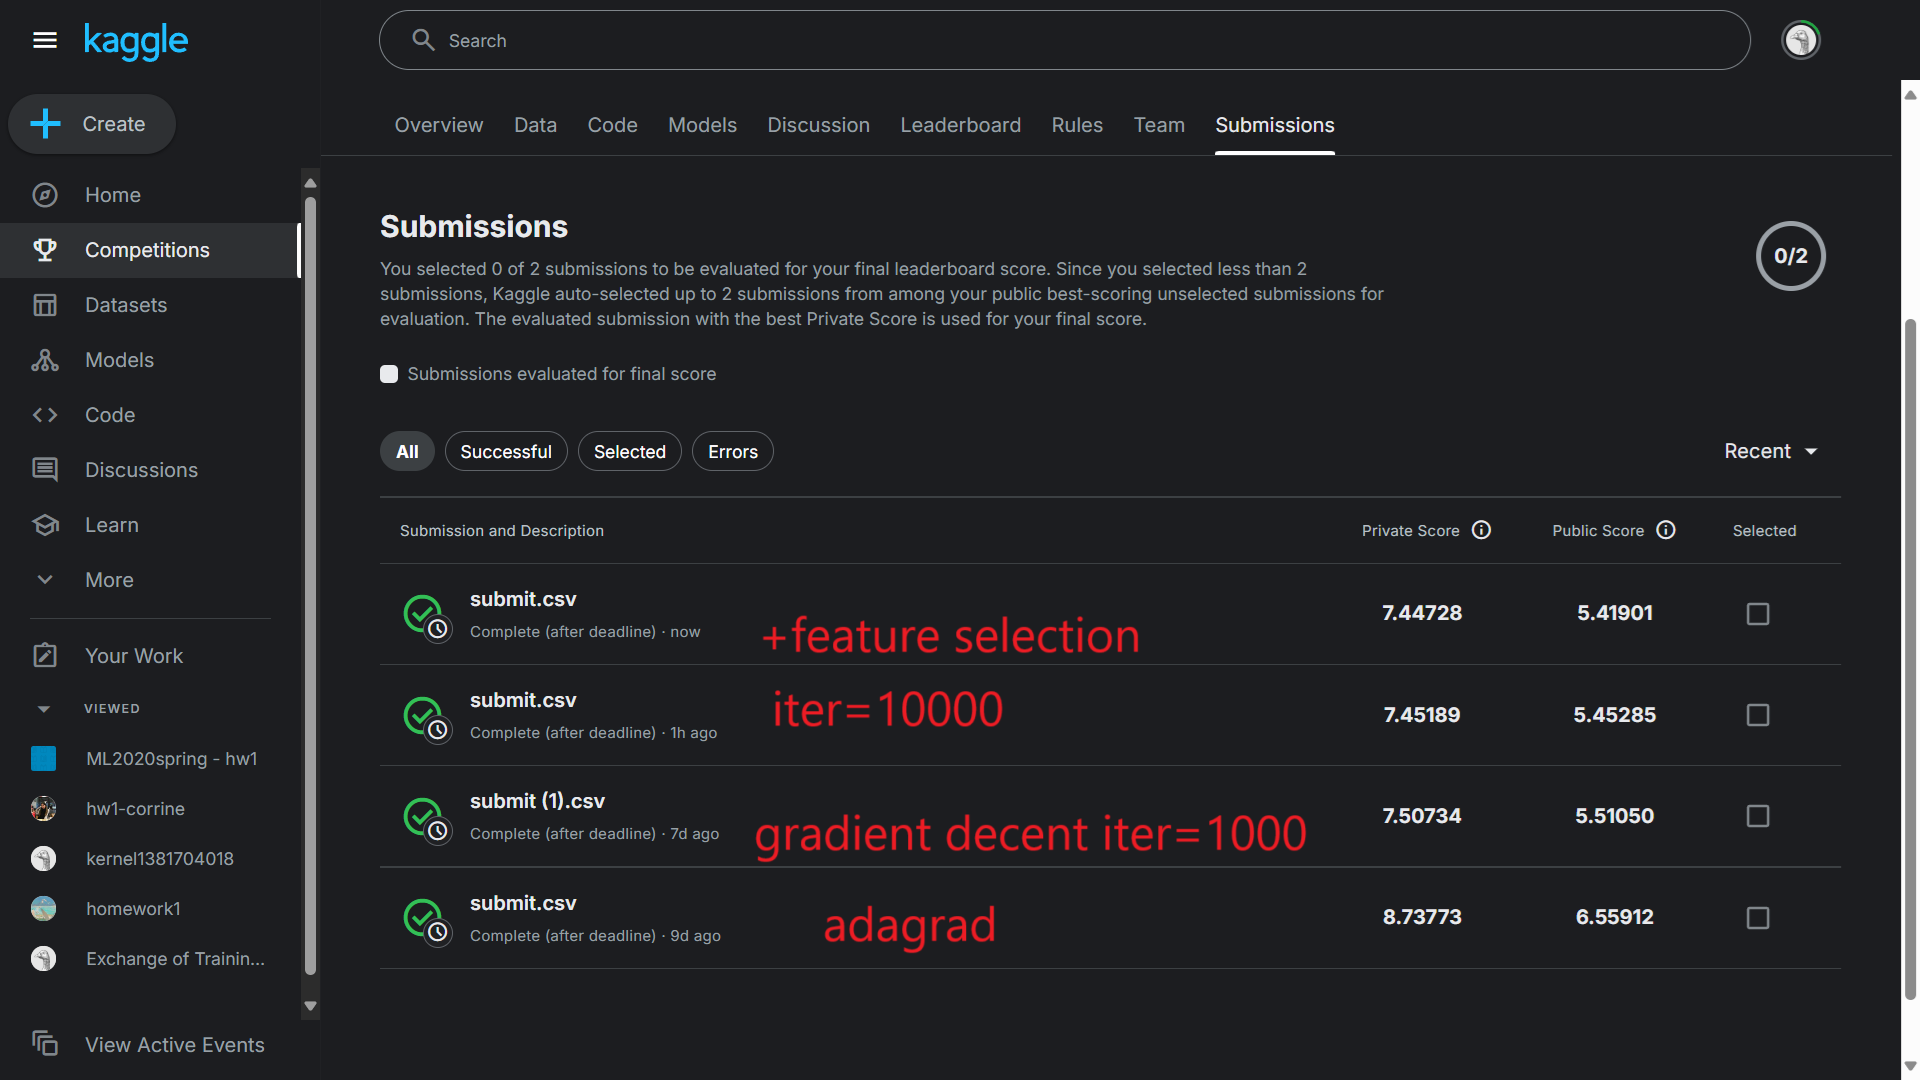

相關 reference 可以參考:

Adagrad :
https://youtu.be/yKKNr-QKz2Q?list=PLJV_el3uVTsPy9oCRY30oBPNLCo89yu49&t=705

RMSprop :
https://www.youtube.com/watch?v=5Yt-obwvMHI

Adam
https://www.youtube.com/watch?v=JXQT_vxqwIs


以上 print 的部分主要是為了看一下資料和結果的呈現，拿掉也無妨。另外，在自己的 linux 系統，可以將檔案寫死的的部分換成 sys.argv 的使用 (可在 terminal 自行輸入檔案和檔案位置)。

最後，可以藉由調整 learning rate、iter_time (iteration 次數)、取用 features 的多寡(取幾個小時，取哪些特徵欄位)，甚至是不同的 model 來超越 baseline。

Report 的問題模板請參照 : https://docs.google.com/document/d/1s84RXs2AEgZr54WCK9IgZrfTF-6B1td-AlKR9oqYa4g/edit